In [1]:
import torch
from numpy import genfromtxt
A = torch.tensor(genfromtxt('/Users/shi/Desktop/individual/DTI_fiber_consensus_HCP.csv', delimiter=','))

In [2]:
A

tensor([[  0.0000, 139.1087, 184.5700,  ...,   0.0000,   0.0000,   0.0000],
        [139.1087,   0.0000, 536.3300,  ...,   0.0000,   0.0000,   0.0000],
        [184.5700, 536.3300,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000, 175.9800],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000, 175.9800,   0.0000]],
       dtype=torch.float64)

In [3]:
A.shape

torch.Size([100, 100])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
edge_index = A.nonzero().t().contiguous()
edge_attr = A[edge_index[0], edge_index[1]].to(device).to(torch.float32)

In [6]:
edge_index.shape

torch.Size([2, 2034])

In [7]:
edge_attr.shape

torch.Size([2034])

Each file contains a variable of size [N, D, T] where N=100 is the number of subjects, D={83,100} is the number of regions in the parcellation, and T=1189 is the number of time points in each fMRI session. I recommend we use only the Schaefer-100 for now.

In [8]:
import scipy.io
data83 = scipy.io.loadmat('./HCP_100subj/Lausanne83_BOLD_HCP.mat')
data100 = scipy.io.loadmat('./HCP_100subj/Schaefer100_BOLD_HCP.mat')

In [9]:
data83.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BOLD_timeseries_HCP'])

In [10]:
a=data100['BOLD_timeseries_HCP'][0][0]
a.shape

(100, 1189)

In [11]:
data = data100['BOLD_timeseries_HCP']

In [12]:
for i in range(len(data)):
    data[i][0] = torch.from_numpy(data[i][0]).to(device).to(torch.float32)
    data[i][0] = data[i][0].T

In [13]:
data_tensor = torch.stack([data[i][0] for i in range(len(data))])

In [14]:
import torch

# Compute global mean and standard deviation
mean = torch.mean(data_tensor,dim=(0, 2))  # Mean across the patient and region dimensions
std = torch.std(data_tensor,dim=(0, 2))    # Std deviation across the patient and region dimensions

# Normalize the data tensor
normalized_data = (data_tensor - mean[:, None]) / std[:, None]

In [15]:
def data_normalized(patient_data, batch_size, L=None):
    num_patients = len(patient_data)
    t_length = patient_data[0][0].shape[0]

    while True:
        # Shuffle patient indices at the start of each epoch
        shuffled_indices = torch.randperm(num_patients)

        # Iterate through the shuffled indices in steps of batch_size
        for start_idx in range(0, num_patients, batch_size):
            end_idx = min(start_idx + batch_size, num_patients)
            batch = torch.stack([patient_data[i] for i in shuffled_indices[start_idx:end_idx]])

            if L == None:
                yield batch
            else:
                # Return the batch in chunks of length L
                for i in range(t_length - L + 1):
                    yield batch[:, i : i+L, :]

In [16]:
z=next(data_normalized(normalized_data, 1, L=10))

In [17]:
z.shape

torch.Size([1, 10, 100])

## load model

In [18]:
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer

In [19]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr, u, batch):

        return src[:, 0] * edge_attr

        
class NodeModel(torch.nn.Module):
    def __init__(self, hidden_sizes):
        super().__init__()
        
        num_node_features = 2
        in_channels = 2+1 
        hiddens = 2*in_channels

        layers = []
        input_size = in_channels
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_node_features))
        
        self.node_mlp = nn.Sequential(*layers)
        
    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out = torch.cat([x, out.unsqueeze(1)], dim=1)
        return self.node_mlp(out)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel([16,32,16])).to(device)
model.load_state_dict(torch.load('./grid_search/model_node_16_32_16_lr_0.001.pth'))

<All keys matched successfully>

In [65]:
a = torch.tensor(a).to(device).to(torch.float32)

/var/folders/rr/j6h778k96l3cmvkjn2gmtjt40000gn/T/ipykernel_9731/852718161.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a).to(device).to(torch.float32)


In [41]:
a_expanded = a.unsqueeze(1)
zero_tensor = torch.zeros([a.shape[0], 1, a.shape[1]])
padded_a = torch.cat((a_expanded, zero_tensor), dim=1)

In [51]:
states.dtype

torch.float32

In [55]:
model.eval()

states= padded_a.to(device).to(torch.float32)
state = states[0,:,:]
pred_list = [state]
true_list = [state]
t=0
while t<(a.shape[1]-1):
    x = pred_list[t]
    #print(x.dtype,edge_index.dtype,edge_attr.dtype)
    pred = model(x.T,edge_index,edge_attr)[0].T
    pred_list.append(pred)
    t = t+1

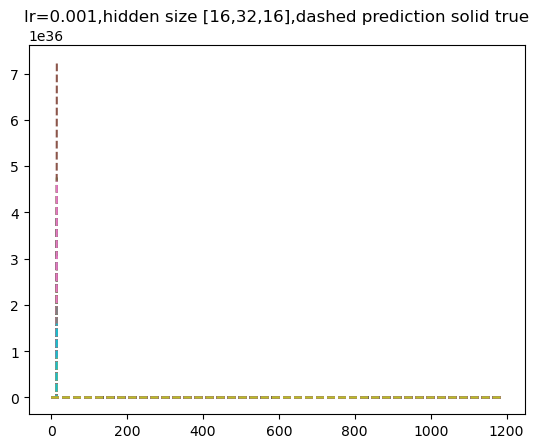

In [56]:
pred_traj = torch.stack(pred_list, dim=0)
plt.plot(pred_traj[:,0,:].detach(),'--',label='prediction')
#plt.plot(true_traj[:500,0,:],label='true')
plt.title('lr=0.001,hidden size [16,32,16],dashed prediction solid true')
plt.show()

### normalise data

In [21]:
edge_min = edge_attr.min()
edge_max = edge_attr.max()
# Normalize
minmax_edge_attr = (edge_attr - edge_min) / (edge_max - edge_min)

In [23]:
a.shape

(100, 1189)

In [24]:
data_mean = a.mean(dim=1, keepdim=True)
data_std = a.std(dim=1, keepdim=True)
normalized_data = (a - data_mean) / data_std

TypeError: _mean() got an unexpected keyword argument 'dim'

In [69]:
data_expanded = normalized_data.unsqueeze(1)
zero_tensor = torch.zeros([a.shape[0], 1, a.shape[1]])
padded_data = torch.cat((data_expanded, zero_tensor), dim=1)

In [90]:
model.eval()

states= padded_data.to(device).to(torch.float32)
states = states.T
state = states[0,:,:]
pred_list = [state]
true_list = [state]
t=0
while t<(a.shape[1]-1):
    x = pred_list[t]
    #print(x.dtype,edge_index.dtype,edge_attr.dtype)
    pred = model(x.T,edge_index,minmax_edge_attr)[0].T
    pred_list.append(pred)
    t = t+1

In [91]:
states.shape

torch.Size([1189, 2, 100])

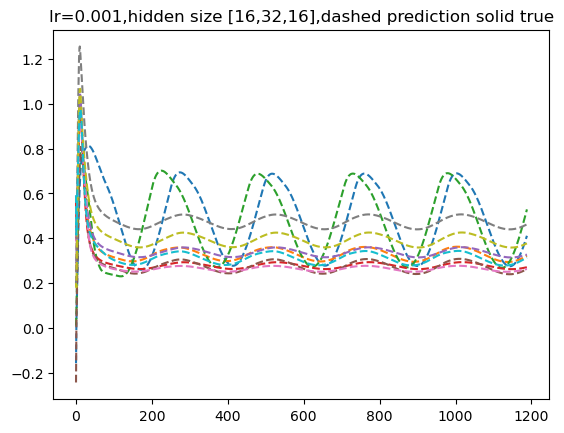

In [95]:
pred_traj = torch.stack(pred_list, dim=0)
plt.plot(pred_traj[:,0,:10].detach(),'--',label='prediction')
#plt.plot(states[:,0,:10],label='true')
plt.title('lr=0.001,hidden size [16,32,16],dashed prediction solid true')
plt.show()

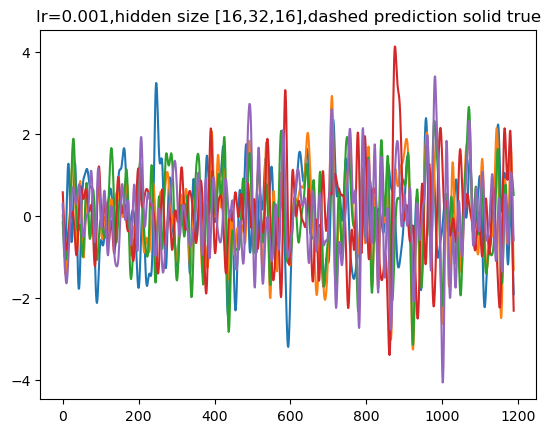

In [87]:
pred_traj = torch.stack(pred_list, dim=0)
#plt.plot(pred_traj[:5,0,:].T.detach(),'--',label='prediction')
plt.plot(states[0,0,:].T,label='true')
plt.title('lr=0.001,hidden size [16,32,16],dashed prediction solid true')
plt.show()

In [25]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr, u, batch):

        return src * edge_attr.unsqueeze(1)

        
class NodeModel(torch.nn.Module):
    def __init__(self, hidden_sizes,look_back):
        super().__init__()
        
        num_node_features = 1
        in_channels = (1+1)*look_back

        layers = []
        input_size = in_channels
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_node_features))
        
        self.node_mlp = nn.Sequential(*layers)
        
    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out = torch.cat([x, out], dim=1)
        return self.node_mlp(out)

In [197]:
# Define your grid
node_hidden_layer_combinations = [[16,32,16]]
learning_rates = [0.001]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_back = 10
look_ahead = 10

max_epochs = 1000000

train_generator = data_normalized(normalized_data, 1, L=look_back+look_ahead)  
valid_generator = data_normalized(normalized_data, 1, L=look_back+look_ahead)  

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    # Create your models with the current hyperparameters
    edge_model = EdgeModel().to(device)
    node_model = NodeModel(node_sizes,look_back).to(device)
    model = MetaLayer(edge_model, node_model).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses = []
    valid_losses = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model.train()
        optimizer.zero_grad()
        
        loss = 0
        #current_state = states[:look_back, :]
        for k in range(look_ahead): 
            current_state = states[k:k + look_back, :]
            prediction = model(current_state.T, edge_index, minmax_edge_attr)[0].T
            loss += loss_fn(prediction, states[k + look_back, :])
            #current_state = torch.cat([current_state[1:], prediction.unsqueeze(0)], dim=0)       
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            for k in range(look_ahead):
                current_state = states[k:k + look_back, :]
                prediction = model(current_state.T, edge_index, minmax_edge_attr)[0].T
                valid_loss += loss_fn(prediction, states[k + look_back, :])
                
            valid_losses.append(valid_loss.item())

        epoch += 1  
        if (epoch + 1) % 20000 == 0: 
            print(f"Epoch {epoch + 1},Current Loss: {loss_value}")

Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.001
Epoch 20000,Current Loss: 0.0037218816578388214
Epoch 40000,Current Loss: 0.13990016281604767
Epoch 60000,Current Loss: 0.002175963018089533
Epoch 80000,Current Loss: 0.0013285578461363912
Epoch 100000,Current Loss: 0.0009491077507846057
Epoch 120000,Current Loss: 0.000567303563002497
Epoch 140000,Current Loss: 0.000687408959493041
Epoch 160000,Current Loss: 0.0017039859667420387
Epoch 180000,Current Loss: 0.0010522218653932214
Epoch 200000,Current Loss: 0.000594440964050591
Epoch 220000,Current Loss: 0.010370554402470589
Epoch 240000,Current Loss: 0.0009171642013825476
Epoch 260000,Current Loss: 0.0007530742441304028
Epoch 280000,Current Loss: 0.0002350582362851128
Epoch 300000,Current Loss: 0.0003876642440445721
Epoch 320000,Current Loss: 0.0003973969432990998
Epoch 340000,Current Loss: 0.0009443040471524
Epoch 360000,Current Loss: 0.0007350262021645904
Epoch 380000,Current Loss: 0.0006028555799275637
Epoch 400000,

In [209]:
model.eval()
sim_length=400
test_generator = data_normalized(normalized_data, 1, L=None)
states= next(test_generator)
states= states.to(device)
if states.shape[0] == 1:
    states = states.squeeze(0)
pred_list = states[:look_back, :]
for k in range(500): 
    current_state = pred_list[k:k + look_back, :]
    prediction = model(current_state.T, edge_index, minmax_edge_attr)[0].T #one time step
    pred_list = torch.cat((pred_list, prediction))
    

In [211]:
pred_list.shape

torch.Size([510, 100])

In [201]:
states.shape

torch.Size([1189, 100])

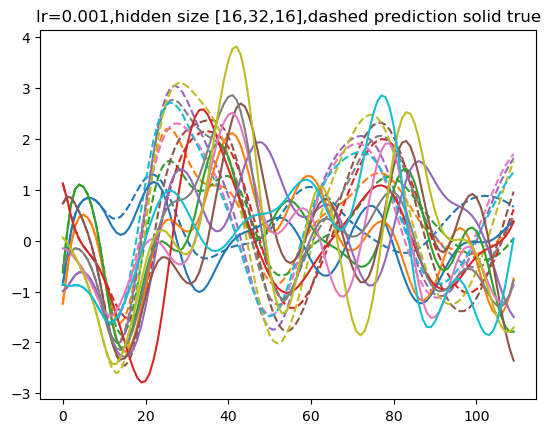

In [217]:
plt.plot(pred_list[:110,:10].detach(),'--',label='prediction')
plt.plot(states[:110,:10],label='true')
plt.title('lr=0.001,hidden size [16,32,16],dashed prediction solid true')
plt.show()

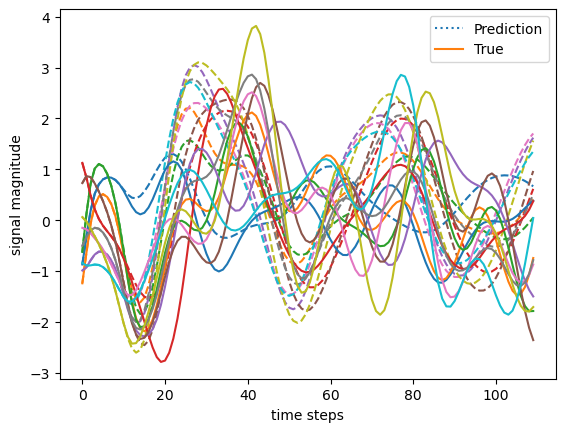

In [219]:
plt.plot(pred_list[:110,:10].detach(),'--',label='prediction')
plt.plot(states[:110,:10],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], linestyle=':', color='C0', label='Prediction'),
                   Line2D([0], [0], linestyle='-', color='C1', label='True')]
plt.legend(handles=legend_elements)
plt.show()

In [232]:
model.eval()
sim_length=400
pred_list_gn = test_states[:look_back, :]
for k in range(500): 
    current_state = pred_list_gn[k:k + look_back, :]
    prediction = model(current_state.T, edge_index, minmax_edge_attr)[0].T #one time step
    pred_list_gn = torch.cat((pred_list_gn, prediction))    

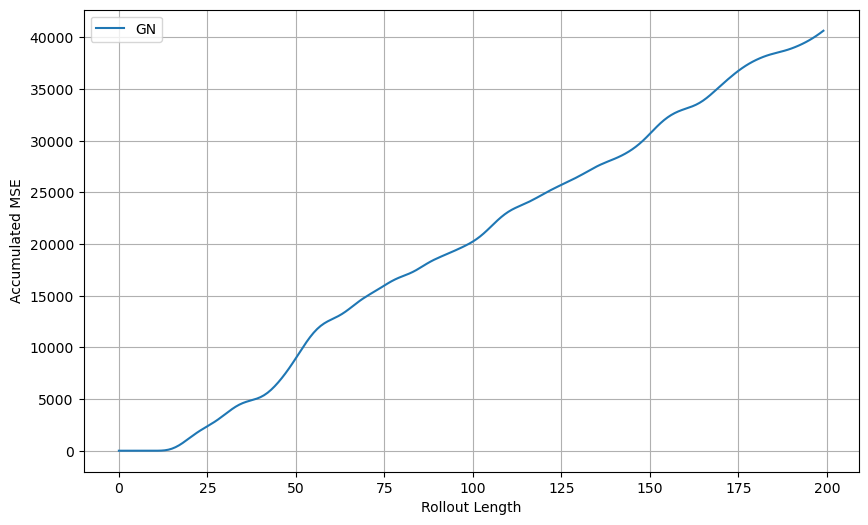

In [220]:
# Calculate MSE for each rollout length
mse_values = []
mse_loss = nn.MSELoss(reduction='sum')
mse_rollout = 200
for i in range(mse_rollout):
    mse = mse_loss(states[:i+1,:], pred_list[:i+1,:].detach())
    mse_values.append(mse)
    

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(mse_values,label='GN')
plt.xlabel('Rollout Length')
plt.ylabel('Accumulated MSE')
plt.legend()
plt.grid(True)
plt.show()

In [223]:
torch.save(model.state_dict(), 'real_data_gn.pth')

## baseline model for comparison

In [26]:
class SimpleMLP(nn.Module):
    def __init__(self, hidden_sizes):
        super(SimpleMLP, self).__init__()
        
        input_size = 10
        output_size = 1
        
        layers = []
        current_input = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_input, hidden_size))
            layers.append(nn.ReLU())
            current_input = hidden_size

        layers.append(nn.Linear(current_input, output_size))
        
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [226]:
# Define your grid
node_hidden_layer_combinations = [[16,32,16]]
learning_rates = [0.001]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_back = 10
look_ahead = 10

max_epochs = 1000000

train_generator = data_normalized(normalized_data, 1, L=look_back+look_ahead)  
valid_generator = data_normalized(normalized_data, 1, L=look_back+look_ahead)  

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    model_mlp = SimpleMLP(node_sizes).to(device)

    optimizer = optimizer_class(model_mlp.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses_mlp = []
    valid_losses_mlp = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model_mlp.train()
        optimizer.zero_grad()
        
        loss = 0
        #current_state = states[:look_back, :]
        for k in range(look_ahead): 
            current_state = states[k:k + look_back, :]
            prediction = model_mlp(current_state.T).T
            loss += loss_fn(prediction, states[k + look_back, :])
            #current_state = torch.cat([current_state[1:], prediction.unsqueeze(0)], dim=0)       
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses_mlp.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model_mlp.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            for k in range(look_ahead):
                current_state = states[k:k + look_back, :]
                prediction = model_mlp(current_state.T).T
                valid_loss += loss_fn(prediction, states[k + look_back, :])
                
            valid_losses_mlp.append(valid_loss.item())

        epoch += 1  
        if (epoch + 1) % 20000 == 0: 
            print(f"Epoch {epoch + 1},Current Loss: {loss_value}")

Training for Node Hidden Sizes: [16, 32, 16] and Learning Rate: 0.001
Epoch 20000,Current Loss: 0.0007380376337096095
Epoch 40000,Current Loss: 0.00041693131788633764
Epoch 60000,Current Loss: 0.00040967061067931354
Epoch 80000,Current Loss: 0.0012515608686953783
Epoch 100000,Current Loss: 0.0007665467564947903
Epoch 120000,Current Loss: 0.0005761591019108891
Epoch 140000,Current Loss: 0.0008684118511155248
Epoch 160000,Current Loss: 0.001239695935510099
Epoch 180000,Current Loss: 0.0009688516147434711
Epoch 200000,Current Loss: 0.0005177116254344583
Epoch 220000,Current Loss: 0.003015846712514758
Epoch 240000,Current Loss: 0.0004757472197525203
Epoch 260000,Current Loss: 0.0002861407119780779
Epoch 280000,Current Loss: 0.0002616031270008534
Epoch 300000,Current Loss: 0.0005042494158260524
Epoch 320000,Current Loss: 0.00011257718870183453
Epoch 340000,Current Loss: 0.00042950132046826184
Epoch 360000,Current Loss: 0.00043468622607178986
Epoch 380000,Current Loss: 0.0007804578053764999


In [227]:
model_mlp.eval()
sim_length=400
test_generator = data_normalized(normalized_data, 1, L=None)
test_states= next(test_generator)
test_states= test_states.to(device)
if test_states.shape[0] == 1:
    test_states = test_states.squeeze(0)
pred_list_mlp = test_states[:look_back, :]
for k in range(500): 
    current_state = pred_list_mlp[k:k + look_back, :]
    prediction = model_mlp(current_state.T).T #one time step
    pred_list_mlp = torch.cat((pred_list_mlp, prediction))
    

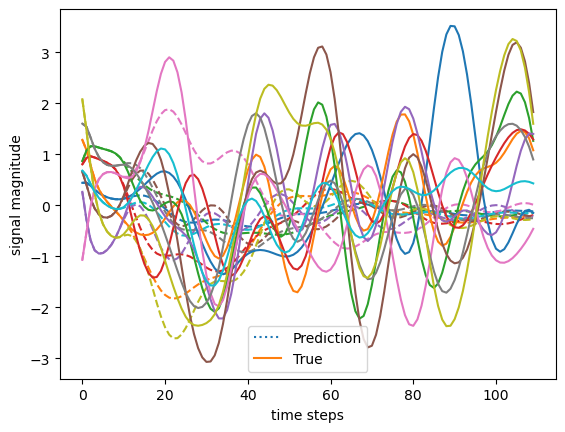

In [228]:
plt.plot(pred_list_mlp[:110,:10].detach(),'--',label='prediction')
plt.plot(test_states[:110,:10],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.legend(handles=legend_elements)
plt.show()

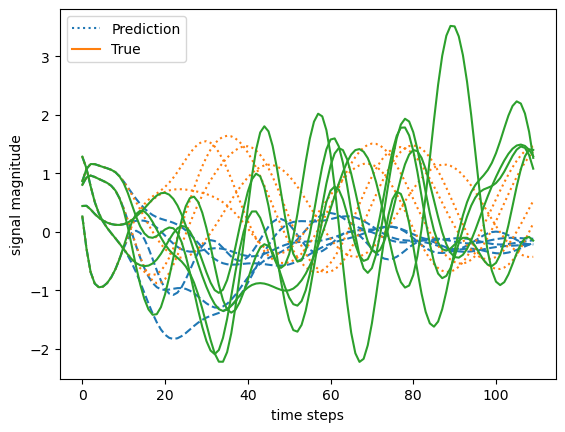

In [244]:
plt.plot(pred_list_mlp[:110,:5].detach(),'C0--',label='prediction')
plt.plot(pred_list_gn[:110,:5].detach(),'C1:',label='prediction')
plt.plot(test_states[:110,:5],'C2',label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.legend(handles=legend_elements)
plt.show()

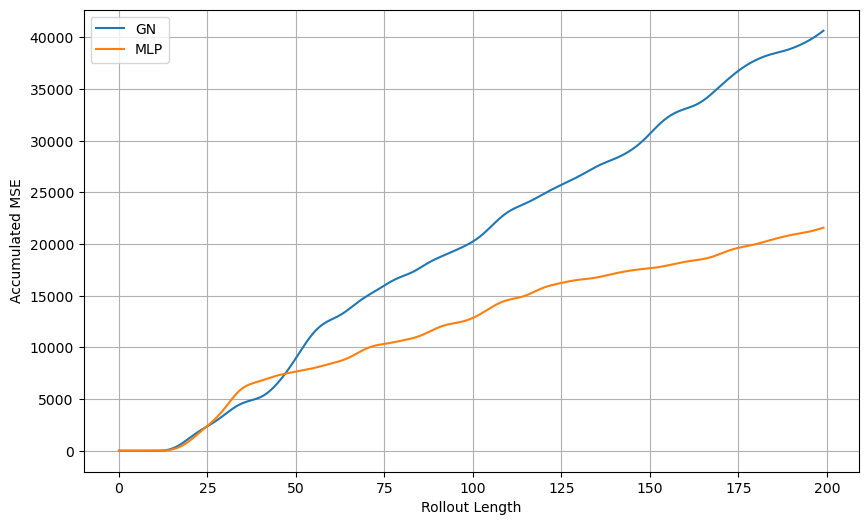

In [229]:
# Calculate MSE for each rollout length
mse_values_mlp = []
mse_loss = nn.MSELoss(reduction='sum')
mse_rollout = 200
for i in range(mse_rollout):
    mse = mse_loss(test_states[:i+1,:], pred_list_mlp[:i+1,:].detach())
    mse_values_mlp.append(mse)
    

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(mse_values,label='GN')
plt.plot(mse_values_mlp,label='MLP')
plt.xlabel('Rollout Length')
plt.ylabel('Accumulated MSE')
plt.legend()
plt.grid(True)
plt.show()

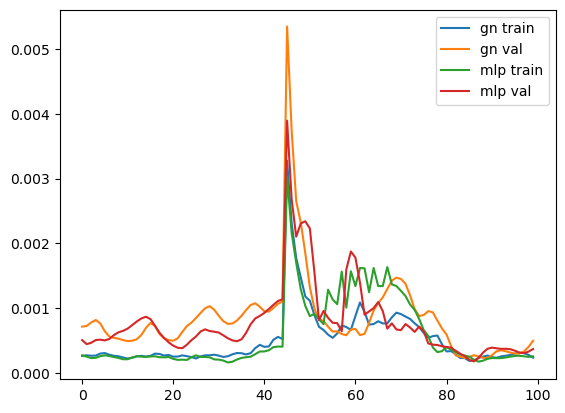

In [246]:
plt.plot(train_losses[-100:],label='gn train')
plt.plot(valid_losses[-100:],label='gn val')
plt.plot(train_losses_mlp[-100:],label='mlp train')
plt.plot(valid_losses_mlp[-100:],label='mlp val')
plt.legend()
plt.show()

In [247]:
print(sum(valid_losses[-10000:]) / 10000, sum(valid_losses_mlp[-10000:]) / 10000)

0.0011646066782079287 0.0009105079090462823


In [256]:
torch.save(model_mlp.state_dict(), 'real_data_mlp.pth')

In [30]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, hidden_sizes):
        super(GCN, self).__init__()
        
        self.layers = nn.ModuleList()

        input_size = 10
        
        # Create GCN layers based on hidden_sizes
        for hidden_size in hidden_sizes:
            self.layers.append(GCNConv(input_size, hidden_size))
            input_size = hidden_size
            
        self.layers.append(GCNConv(input_size, 1))

    def forward(self, x, edge_index, edge_attr):
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x, edge_index, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            
        x = self.layers[-1](x, edge_index, edge_attr)
        return x


In [251]:
# Define your grid
node_hidden_layer_combinations = [[16, 32, 64, 32, 16]]
learning_rates = [0.01]

grid = [(n_sizes, lr) for n_sizes in node_hidden_layer_combinations for lr in learning_rates]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer_class = torch.optim.Adam
loss_fn = nn.MSELoss()
look_back = 10
look_ahead = 10

max_epochs = 1000000

train_generator = data_normalized(normalized_data, 1, L=look_back+look_ahead)  
valid_generator = data_normalized(normalized_data, 1, L=look_back+look_ahead)  

# Start the grid search
results = []
for node_sizes, learning_rate in grid:
    print(f"Training for Node Hidden Sizes: {node_sizes} and Learning Rate: {learning_rate}")

    model_gcn = GCN(node_sizes).to(device)

    optimizer = optimizer_class(model_gcn.parameters(), lr=learning_rate, weight_decay=5e-4)
    
    train_losses_gcn = []
    valid_losses_gcn = []
    epoch = 0
    loss_value = float('inf')
    
    # Your training loop remains largely unchanged
    while loss_value > 1e-6 and epoch < max_epochs:
        # Training step
        states = next(train_generator)
        states = states.to(device)
        if states.shape[0] == 1:
            states = states.squeeze(0)
        
        model_gcn.train()
        optimizer.zero_grad()
        
        loss = 0
        #current_state = states[:look_back, :]
        for k in range(look_ahead): 
            current_state = states[k:k + look_back, :]
            prediction = model_gcn(current_state.T,edge_index, minmax_edge_attr).T
            loss += loss_fn(prediction, states[k + look_back, :])
            #current_state = torch.cat([current_state[1:], prediction.unsqueeze(0)], dim=0)       
        loss.backward()
        optimizer.step()
        
        # Store and print the loss
        loss_value = loss.item()
        train_losses_gcn.append(loss_value)
        
        # Validation step
        with torch.no_grad():
            model_gcn.eval()  # Switch the model to evaluation mode
            states = next(valid_generator)
            states = states.to(device)
            if states.shape[0] == 1:
                states = states.squeeze(0)
            
            valid_loss = 0
            for k in range(look_ahead):
                current_state = states[k:k + look_back, :]
                prediction = model_gcn(current_state.T,edge_index, minmax_edge_attr).T
                valid_loss += loss_fn(prediction, states[k + look_back, :])
                
            valid_losses_gcn.append(valid_loss.item())

        epoch += 1  
        if (epoch + 1) % 20000 == 0: 
            print(f"Epoch {epoch + 1},Current Loss: {loss_value}")

Training for Node Hidden Sizes: [16, 32, 64, 32, 16] and Learning Rate: 0.01
Epoch 20000,Current Loss: 8.564051628112793
Epoch 40000,Current Loss: 4.262077331542969
Epoch 60000,Current Loss: 18.916399002075195
Epoch 80000,Current Loss: 10.938175201416016
Epoch 100000,Current Loss: 4.986381530761719
Epoch 120000,Current Loss: 6.904038429260254
Epoch 140000,Current Loss: 8.932421684265137
Epoch 160000,Current Loss: 4.063971042633057
Epoch 180000,Current Loss: 5.540884494781494
Epoch 200000,Current Loss: 19.915264129638672
Epoch 220000,Current Loss: 8.333909034729004
Epoch 240000,Current Loss: 12.528285026550293
Epoch 260000,Current Loss: 11.520384788513184
Epoch 280000,Current Loss: 7.466116428375244
Epoch 300000,Current Loss: 6.925746917724609
Epoch 320000,Current Loss: 10.200003623962402
Epoch 340000,Current Loss: 20.98752212524414
Epoch 360000,Current Loss: 10.095561027526855
Epoch 380000,Current Loss: 6.147289276123047
Epoch 400000,Current Loss: 11.026435852050781
Epoch 420000,Curren

In [253]:
model_gcn.eval()
pred_list_gcn = test_states[:look_back, :]
for k in range(500): 
    current_state = pred_list_gcn[k:k + look_back, :]
    prediction = model_gcn(current_state.T,edge_index, minmax_edge_attr).T #one time step
    pred_list_gcn = torch.cat((pred_list_gcn, prediction))
    

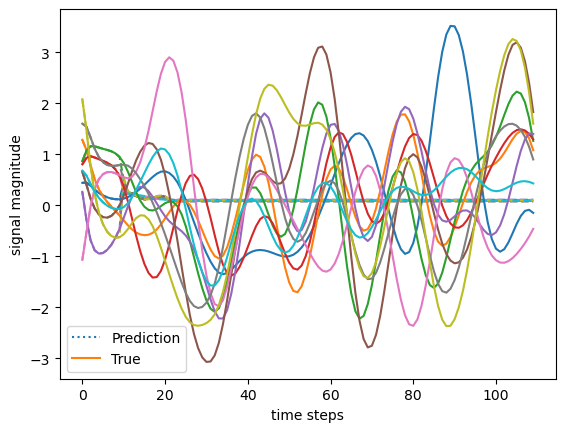

In [254]:
plt.plot(pred_list_gcn[:110,:10].detach(),'--',label='prediction')
plt.plot(test_states[:110,:10],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.legend(handles=legend_elements)
plt.show()

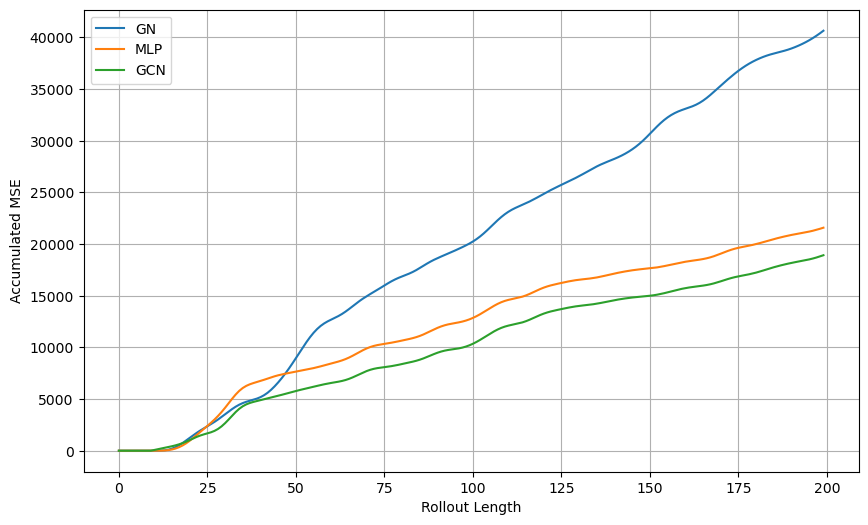

In [255]:
# Calculate MSE for each rollout length
mse_values_gcn = []
mse_loss = nn.MSELoss(reduction='sum')
mse_rollout = 200
for i in range(mse_rollout):
    mse = mse_loss(test_states[:i+1,:], pred_list_gcn[:i+1,:].detach())
    mse_values_gcn.append(mse)
    

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(mse_values,label='GN')
plt.plot(mse_values_mlp,label='MLP')
plt.plot(mse_values_gcn,label='GCN')
plt.xlabel('Rollout Length')
plt.ylabel('Accumulated MSE')
plt.legend()
plt.grid(True)
plt.show()

In [257]:
torch.save(model_gcn.state_dict(), 'real_data_gcn.pth')

## report

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel([16,32,16],10)).to(device)
model.load_state_dict(torch.load('real_data_gn.pth'))
model_mlp = SimpleMLP([16,32,16]).to(device)
model_mlp.load_state_dict(torch.load('real_data_mlp.pth'))
model_gcn = GCN([16, 32, 64, 32, 16]).to(device)
model_gcn.load_state_dict(torch.load('real_data_gcn.pth'))

<All keys matched successfully>

In [49]:
model.eval()
model_mlp.eval()
model_gcn.eval()
look_back = 10
test_generator = data_normalized(normalized_data, 1, L=None)
test_states= next(test_generator)
test_states= test_states.to(device)
if test_states.shape[0] == 1:
    test_states = test_states.squeeze(0)
    
pred_list = test_states[:look_back, :]
pred_list_mlp = test_states[:look_back, :]
pred_list_gcn = test_states[:look_back, :]
for k in range(500): 
    current_state = pred_list[k:k + look_back, :]
    prediction = model(current_state.T,edge_index, minmax_edge_attr)[0].T #one time step
    pred_list = torch.cat((pred_list, prediction))
    
    current_state = pred_list_mlp[k:k + look_back, :]
    prediction = model_mlp(current_state.T).T #one time step
    pred_list_mlp = torch.cat((pred_list_mlp, prediction))
    
    current_state = pred_list_gcn[k:k + look_back, :]
    prediction = model_gcn(current_state.T,edge_index, minmax_edge_attr).T #one time step
    pred_list_gcn = torch.cat((pred_list_gcn, prediction))
    

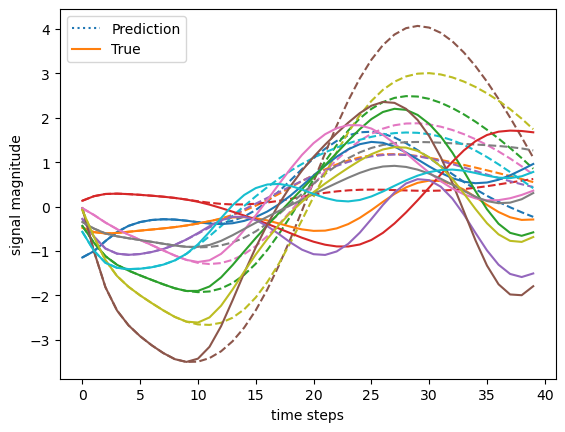

In [58]:
plt.plot(pred_list[:40,:10].detach(),'--',label='prediction')
plt.plot(test_states[:40,:10],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.legend(handles=legend_elements)
plt.show()

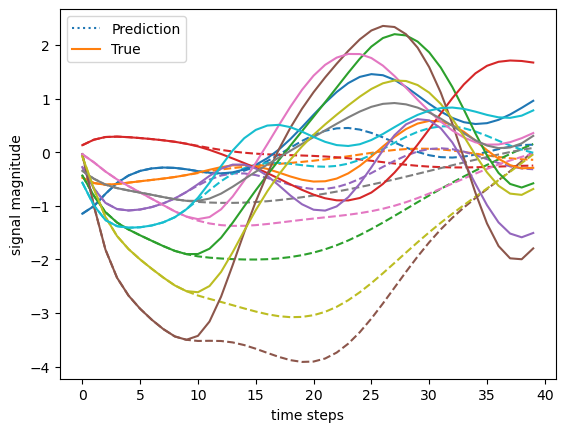

In [59]:
plt.plot(pred_list_mlp[:40,:10].detach(),'--',label='prediction')
plt.plot(test_states[:40,:10],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
plt.legend(handles=legend_elements)
plt.show()

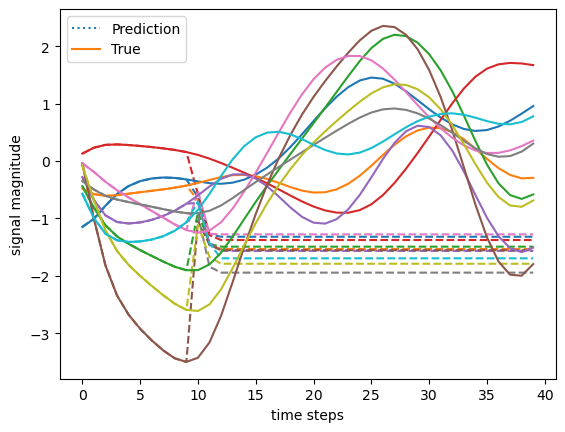

In [60]:
import matplotlib.pyplot as plt
plt.plot(pred_list_gcn[:40,:10].detach(),'--',label='prediction')
plt.plot(test_states[:40,:10],label='true')
plt.xlabel('time steps')
plt.ylabel('signal magnitude')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], linestyle=':', color='C0', label='Prediction'),
                   Line2D([0], [0], linestyle='-', color='C1', label='True')]
plt.legend(handles=legend_elements)
plt.show()

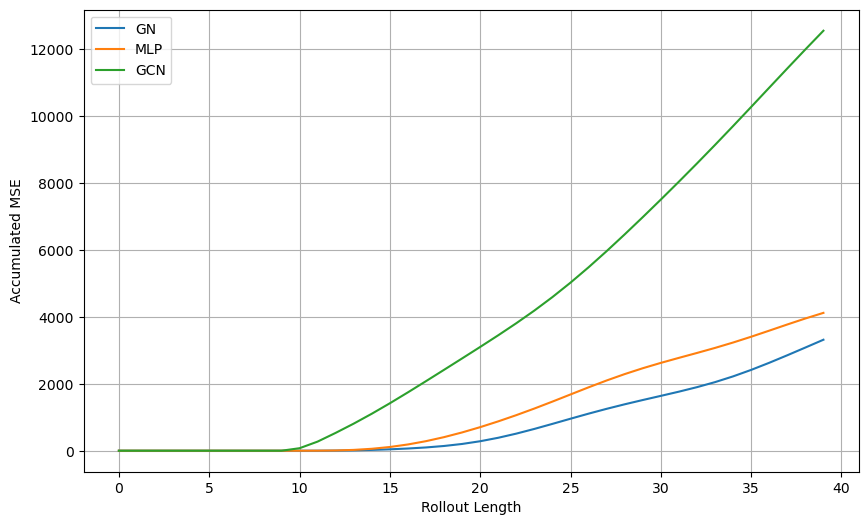

In [57]:
# Calculate MSE for each rollout length
mse_values = []
mse_values_mlp = []
mse_values_gcn = []
mse_loss = nn.MSELoss(reduction='sum')
mse_rollout = 40
for i in range(mse_rollout):
    mse = mse_loss(test_states[:i+1,:], pred_list[:i+1,:].detach())
    mse_values.append(mse)
    mse = mse_loss(test_states[:i+1,:], pred_list_mlp[:i+1,:].detach())
    mse_values_mlp.append(mse)
    mse = mse_loss(test_states[:i+1,:], pred_list_gcn[:i+1,:].detach())
    mse_values_gcn.append(mse)
    

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(mse_values,label='GN')
plt.plot(mse_values_mlp,label='MLP')
plt.plot(mse_values_gcn,label='GCN')
plt.xlabel('Rollout Length')
plt.ylabel('Accumulated MSE')
plt.legend()
plt.grid(True)
plt.show()

In [171]:
generator = data_normalized(normalized_data, 1, L=20) 
states = next(generator)

Minimum Value: 0.0
Maximum Value: 1230.74


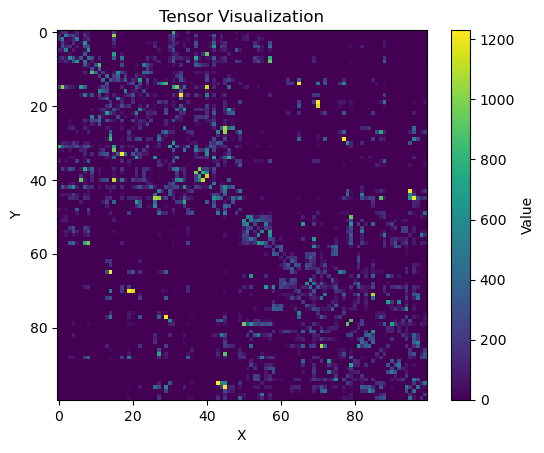

In [65]:
min_val = torch.min(A)
max_val = torch.max(A)

print(f"Minimum Value: {min_val}")
print(f"Maximum Value: {max_val}")

# visualize the tensor
plt.imshow(A, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Tensor Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

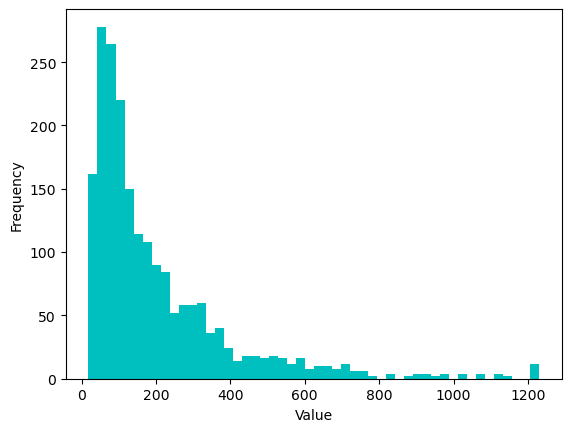

In [69]:
# convert to 1D tensor
tensor_1d = A.view(-1)
# filter out zeros
non_zero_elements = tensor_1d[tensor_1d.nonzero(as_tuple=True)]

# plot histogram
plt.hist(non_zero_elements, bins=50, color='c')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


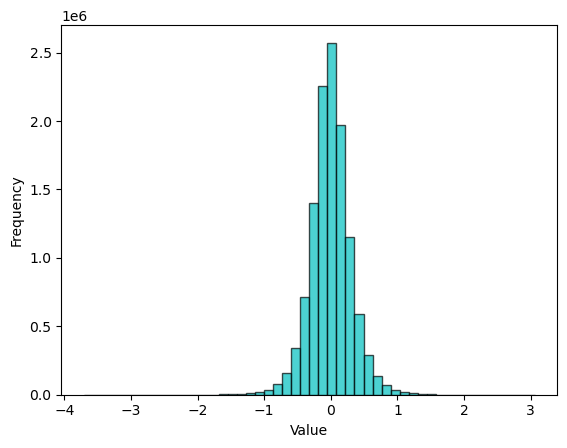

In [72]:
flat_data = data_tensor.flatten()

# Create the histogram
plt.hist(flat_data, bins=50, color='c', edgecolor='k', alpha=0.7)

plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

In [176]:
look_ahead = 10
look_back = 10
states = states.squeeze(0)
for k in range(look_ahead):
    # Use the k-th segment of length `look_back` from states as current_state
    x = states[k:k + look_back, :]
    y = states[k + look_back, :]
    print(k,x.shape,y.shape)


0 torch.Size([10, 100]) torch.Size([100])
1 torch.Size([10, 100]) torch.Size([100])
2 torch.Size([10, 100]) torch.Size([100])
3 torch.Size([10, 100]) torch.Size([100])
4 torch.Size([10, 100]) torch.Size([100])
5 torch.Size([10, 100]) torch.Size([100])
6 torch.Size([10, 100]) torch.Size([100])
7 torch.Size([10, 100]) torch.Size([100])
8 torch.Size([10, 100]) torch.Size([100])
9 torch.Size([10, 100]) torch.Size([100])


In [185]:
a=torch.tensor([1,2,3])
b=torch.tensor([2,3,4])
print(a*b)

tensor([ 2,  6, 12])


In [73]:
normalized_data.shape

torch.Size([100, 1189, 100])